In [68]:
import os 
import glob
from pathlib import Path
from rtmag.paper.parse import parse_tai_string
from sunpy.map import Map
import numpy as np
from skimage.transform import resize
from rtmag.paper.load import load_input_label, MyModel
from rtmag.paper.metric import energy
import matplotlib.pyplot as plt

In [69]:
data_path = "/mnt/f/sdo_AR/NOAA11158_HARP377/hmi"
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [70]:
ix = 240
data_path = data_paths[ix]
data_path

('/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bp.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bt.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Br.fits')

In [71]:
hmi_p, hmi_t, hmi_r, = data_path
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [72]:
from rtmag.paper.load import load_input_label, MyModel

In [73]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [74]:
idx = 13
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz'),
 PosixPath('/mnt/f/isee_dataset/11158/label/label_11158_20110214_000000.npz'))

In [100]:
sharp = hmi_data
sharp.shape

(744, 377, 3)

In [118]:
isee = np.load(input_files[idx])['input'][:, :, :, 0].transpose(1, 2, 0)[:-1, :-1, :]
isee.shape

(512, 256, 3)

In [119]:
isee_x = isee[..., 0]
isee_y = isee[..., 1]
isee_z = isee[..., 2]

In [102]:
from scipy.interpolate import griddata

In [103]:
grid_x, grid_y = np.mgrid[0:1:512j, 0:1:256j]

In [92]:
sharp_x = sharp[..., 0]
sharp_y = sharp[..., 1]
sharp_z = sharp[..., 2]

In [111]:
coords = np.stack(np.mgrid[:sharp.shape[0], :sharp.shape[1]], -1).astype(np.float32)
coords = coords.reshape(-1, 2)
coords.shape

(280488, 2)

In [114]:
coords[:, 0]  = coords[:, 0] / (sharp.shape[0] - 1)
coords[:, 1]  = coords[:, 1] / (sharp.shape[1] - 1)

In [115]:
coords

array([[0.        , 0.        ],
       [0.        , 0.00265957],
       [0.        , 0.00531915],
       ...,
       [1.        , 0.9946808 ],
       [1.        , 0.99734044],
       [1.        , 1.        ]], dtype=float32)

In [123]:
grid_in = griddata(coords, sharp_x.flatten(), (grid_x, grid_y), method='cubic')
grid_in.shape

(512, 256)

In [124]:
grid_in

array([[ -61.95999908,   89.04976332,  -37.46114894, ...,  128.53017162,
          33.88738122,    8.03999996],
       [ -52.33442487,   74.89437548,   -6.43966553, ...,   69.93635639,
         -54.03013523,   45.66614441],
       [ -65.48542275,  -89.1851788 ,  -60.80028315, ...,   -4.65393994,
         -14.81799936,   16.87663399],
       ...,
       [  31.44104139,  -15.90622659,   63.23234169, ...,  -18.60382649,
         -10.72930853,  -47.4794642 ],
       [  48.59235479,  -79.71644201,   32.78501669, ...,  -40.02311587,
         -54.9518741 ,  -29.87282537],
       [ -41.33000183,   48.07327715, -118.49858408, ...,  -58.06163509,
         -89.66251999,  -70.37000275]])

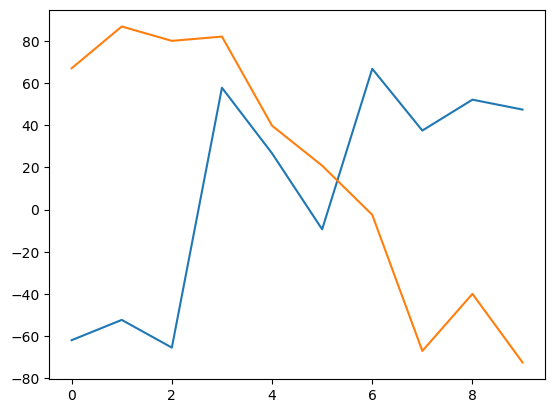

In [134]:
plt.plot(grid_in[:10, 0])
plt.plot(isee_x[:10, 0])

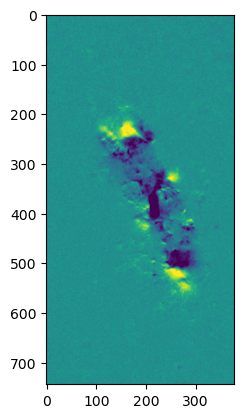

In [137]:
plt.imshow(sharp_x, vmin=-1000, vmax=1000)

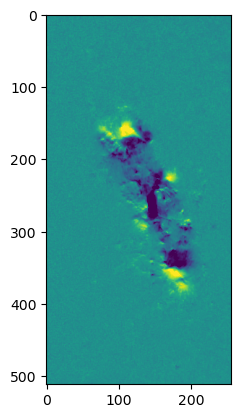

In [138]:
plt.imshow(grid_in, vmin=-1000, vmax=1000)

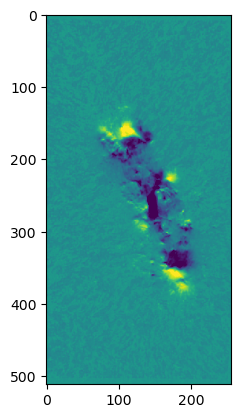

In [139]:
plt.imshow(isee_x, vmin=-1000, vmax=1000)